In [1]:
import os
import pandas as pd 
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

os.environ['WANDB_API_KEY'] = "01007ec4b6d5e5d187bf0ed4d6c790a53a85f105"

In [2]:
def get_runs(filters, proj='struct_mlp', tune_on='test', avg_seeds=True, keep_name=False):
    api = wandb.Api()
    runs = api.runs(proj, filters=filters, order='-created_at')
    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_dict = {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
    }
    runs_df = pd.DataFrame(runs_dict)


    runs_df = runs_df[runs_df['summary'].apply(lambda x: x != {})]
    keys = ['model', 'optimizer', 'width', 'depth', 'struct', 'layers', 'rank_frac', 'tt_rank', 'num_blocks', 'cola_params', 'cola_flops', 'lr', 'seed']
    
    for key in keys:
        if key == 'struct':
            # If 'struct' is None, use the value from 'cola_strategy'
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else x.get('cola_strategy', None))
        elif key == 'layers':
            # If 'layers' is None, default to 'all_but_last'
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 'all_but_last')
        elif key == 'lr':
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 5e-5)
        else:
            # For other keys, just extract the value if it exists
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x else -1)
    runs_df['first_layer_flops'] = runs_df['width'] * (32 * 32 * 3)
    # rank_frac == 1 if struct is not low_rank
    runs_df.loc[~runs_df['struct'].isin(['low_rank', 'low_rank_and_kron', 'sum']), 'rank_frac'] = 1
        
    for key in ['test_acc', 'train_acc', 'train_acc_avg', 'train_loss_avg', 'epoch', 'test_loss', 'val_loss', 'val_acc', '_runtime', 'dh_avg_2']:
        runs_df[key] = runs_df['summary'].apply(lambda x: x[key] if key in x else -1)
    runs_df['runtime'] = runs_df['_runtime'].apply(lambda x: x / 60) # convert to minutes
    runs_df['test_error'] = 100 - runs_df['test_acc']
    runs_df['val_error'] = 100 - runs_df['val_acc']
    runs_df['train_error'] = 100 - runs_df['train_acc']
    runs_df['train_error_avg'] = 100 - runs_df['train_acc_avg']
    
    not_nans = ['width', 'depth', 'test_acc', 'train_acc', 'epoch', 'test_loss']
    runs_df = runs_df[runs_df[not_nans].notna().all(axis=1)]
    # replace nans with None
    runs_df = runs_df.fillna(value='None')

    # delete summary and config, optionally keep name
    if keep_name:
        runs_df = runs_df.drop(columns=['summary', 'config'])
    else:
        runs_df = runs_df.drop(columns=['summary', 'config', 'name'])
    runs_df.loc[(runs_df['struct'] == 'none'), 'layers'] = 'none'

    # Everything else being equal, only keep the best run
    if tune_on is not None:
        if 'loss' in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
        
    # average over seeds
    if avg_seeds:
        keys = [k for k in keys if k != 'seed']
        numeric_cols = runs_df.select_dtypes(include=[np.number]).columns.tolist()
        agg_dict = {col: 'mean' for col in numeric_cols}
        agg_dict.update({col: 'first' for col in keys})
        # If keeping name, aggregate it too (take first)
        if keep_name:
            agg_dict['name'] = 'first'
        
        runs_df = runs_df.groupby(keys).agg(agg_dict).reset_index(drop=True)
    # Tune LR
    if tune_on is not None:
        # remove lr
        keys = [k for k in keys if k != 'lr']
        if 'loss' in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
    return runs_df

In [3]:
struct_names = {
    # 'none': 'Dense',
    # 'dense': 'Dense',
    # 'tt': 'TT',
    # 'kron': 'Kron',
    # 'monarch': 'Monarch',
    'low_rank': 'Low Rank',
    'btt': 'BTT',
    'low_rank_actv': 'Low Rank Actv',
    'btt_actv': 'BTT Actv',
}

### old plotting

In [ ]:
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set(style="whitegrid", font_scale=2.3, rc={"lines.linewidth": 3.0})

xname = 'cola_flops'
xlabel = 'FLOPs'

yname = 'train_error_avg'
ylabel = 'Error [%]'


fit = True

# for ds in ['cifar10', 'cifar100']:
for ds in ['cifar10',]:
    filters = {
        "state": "finished",
        "config.dataset": {"$eq": ds},
        "config.model": {"$eq": 'MLP'},
        "config.depth": 3,
        "config.epochs": 500,
        "config.mixup": 0.8,
        "config.lr": 3e-3,
        "config.use_wrong_mult": False,
        "config.shuffle_pixels": True,
    }

    runs = get_runs(filters, proj=f'mlp_{ds}', tune_on='train_acc_avg', avg_seeds=True)
    runs = runs[runs['struct'].isin(['none', 'btt', 'kron', 'tt', 'monarch', 'low_rank', 'low_rank_actv', 'btt_actv'])] 
    
    # Handle low_rank filter
    runs = runs[~(runs['struct'] == 'low_rank') | (runs['layers'] == 'intermediate')]
    
    # Create a struct_label column that includes rank info for btt_actv
    def create_struct_label(row):
        struct = row['struct']
        if struct == 'btt_actv' and row['tt_rank'] != -1:
            return f"{struct_names.get(struct, struct)} (rank {row['tt_rank']})"
        return struct_names.get(struct, struct)
    
    runs['struct_label'] = runs.apply(create_struct_label, axis=1)
    
    # same struct_label and cola_flops, keep lowest error
    idx = runs.groupby(['struct_label', 'cola_flops'])['train_error_avg'].idxmin()
    runs = runs.loc[idx]
    

    # log log scale, scatter plot
    hue_order = ['Dense', 'BTT', 'Monarch', 'Low Rank', 'Kron', 'TT', 'Low Rank Actv', 'BTT Actv (rank 1)', 'BTT Actv (rank 6)']
    # Filter to only include structs present in the data
    hue_order = [h for h in hue_order if h in runs['struct_label'].unique()]
    pallette = sns.color_palette("Dark2", n_colors=len(hue_order))
    

    plt.figure(dpi=100, figsize=(8, 6))
    if 'train' in yname:
        ax = sns.scatterplot(data=runs, x=xname, y=yname, hue='struct_label', markers=True, hue_order=hue_order, s=300, palette=pallette)
    else:
        ax = sns.lineplot(data=runs, x=xname, y=yname, hue='struct_label', markers=True, palette=pallette, hue_order=hue_order, marker='o', markersize=18, linewidth=3)
    if fit:
        # fit a line on the log log scale, for each struct
        slopes = []
        halfwidths = []
        for struct, color in zip(hue_order, pallette):
            struct_runs = runs[runs['struct_label'] == struct]
            if len(struct_runs) < 2:  # Need at least 2 points for regression
                slopes.append(0)
                halfwidths.append(0)
                continue
            x = np.log(struct_runs[xname])
            y = np.log(struct_runs[yname])
            m, b, r_value, p_value, std_err = stats.linregress(x,y)
            slope_conf_interval = std_err
            slopes.append(-m)
            halfwidths.append(slope_conf_interval)
            plt.plot(struct_runs[xname], np.exp(m * x + b), color=color, linestyle='--', linewidth=3, alpha=1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

    ax.grid(which='minor', axis='y', linestyle='-', linewidth=0.5)
    handles, labels = ax.get_legend_handles_labels()
    # remove legend
    ax.get_legend().remove()
    if yname == 'train_error_avg':
        plt.savefig(f'mlp_{ds}.pdf', bbox_inches='tight')
    else:
        plt.savefig(f'mlp_{ds}_test.pdf', bbox_inches='tight')

    # legend as a separate figure
    legend_fig = plt.figure(figsize=(8, 1))  # Adjuxst size as needed
    ax_legend = legend_fig.add_subplot(111)
    ax_legend.legend(handles, labels, loc='center', ncol=len(labels)//2, columnspacing=0.5, handletextpad=0.2)
    ax_legend.axis('off') 
    plt.tight_layout()
    plt.savefig(f'mlp_{ds}_legend.pdf', bbox_inches='tight')
    # barplot for slopes
    if fit:
        plt.figure(dpi=100, figsize=(3, 6))
        ax = sns.barplot(x=hue_order, y=slopes, palette=pallette)
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=halfwidths, fmt="none", c="k")
        plt.xticks(rotation=45)
        plt.xticks([], [])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        plt.tight_layout()
        plt.savefig(f'mlp_{ds}_slopes.pdf', bbox_inches='tight')

NameError: name 'struct_names' is not defined

### new plotting

Found 5 runs for 'btt_actv_rank_sqrt-low_rank_actv_gelu-mlp_actv_none-20251010_144121'
After removing duplicates: 5 unique FLOPs values
  Scaling exponent α = 0.080 ± 0.004
Found 7 runs for 'btt_rank_sqrt'
After removing duplicates: 7 unique FLOPs values
  Scaling exponent α = 0.096 ± 0.007
Found 8 runs for 'low_rank_actv_20251010_120309'
After removing duplicates: 8 unique FLOPs values
  Scaling exponent α = 0.049 ± 0.002
Found 13 runs for 'low_rank_rank0'
After removing duplicates: 8 unique FLOPs values
  Scaling exponent α = 0.075 ± 0.007


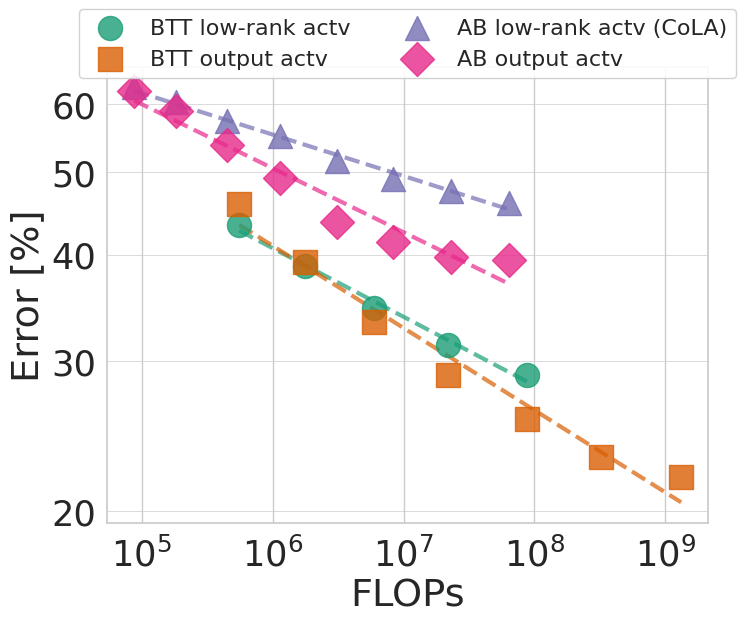

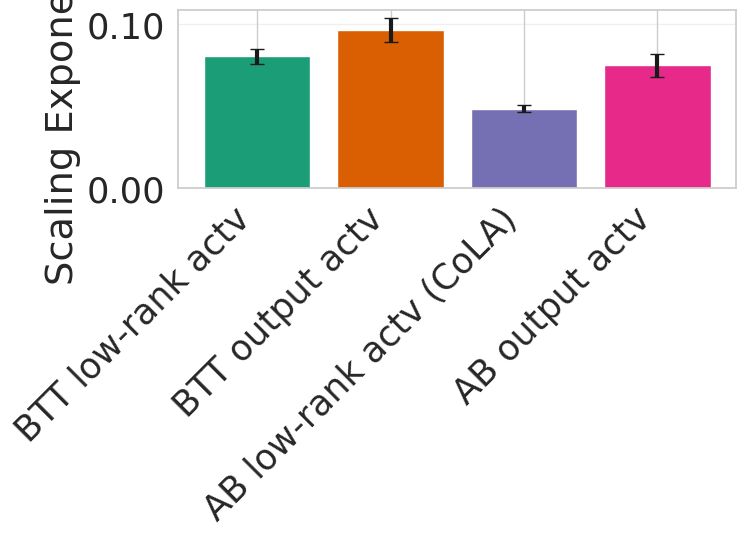

In [12]:
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set(style="whitegrid", font_scale=2.3, rc={"lines.linewidth": 3.0})

xname = 'cola_flops'
xlabel = 'FLOPs'

yname = 'train_error_avg'
ylabel = 'Error [%]'

fit = True

# Define groups to plot: {identifier: display_name}
# groups_to_plot = {
#     'btt_actv_rank_sqrt-low_rank_actv_gelu-mlp_actv_none-20251010_144121': 'BTT low-rank actv',
#     'btt_actv_rank_sqrt_20251009_155943': 'BTT low_rank + output actv',
#     'btt_rank_sqrt': 'BTT output actv',
# }

# groups_to_plot = {
#     'low_rank_actv_low_rank_actv_gelu-mlp_actv_none-20251010_144202': 'low-rank actv',
#     'low_rank_actv_20251010_120309': 'low_rank actv + output actv',
#     'low_rank_rank0': 'output actv',
# }

groups_to_plot = {
    'btt_actv_rank_sqrt-low_rank_actv_gelu-mlp_actv_none-20251010_144121': 'BTT low-rank actv',
    'btt_rank_sqrt': 'BTT output actv',
    'low_rank_actv_20251010_120309': 'AB low-rank actv (CoLA)',
    'low_rank_rank0': 'AB output actv',
}

# Auto-select colors and markers
auto_select = True
if auto_select:
    palette_name = 'Dark2'
    num_groups = len(groups_to_plot)
    colors = sns.color_palette(palette_name, n_colors=num_groups)
    group_colors = {group: colors[i] for i, group in enumerate(groups_to_plot.keys())}
    
    marker_styles = ['o', 's', '^', 'D', 'v', '*', 'p', 'h', 'X', 'P', '<', '>']
    group_markers = {group: marker_styles[i % len(marker_styles)] 
                     for i, group in enumerate(groups_to_plot.keys())}

for ds in ['cifar10']:
    # Use minimal filters to get all runs
    filters = {
        "state": "finished",
        "config.dataset": {"$eq": ds},
        # Uncomment these if you want to be more restrictive:
        # "config.model": {"$eq": 'MLP'},
        # "config.depth": 3,
        # "config.epochs": 500,
        # "config.mixup": 0.8,
        # "config.lr": 3e-3,
        # "config.use_wrong_mult": False,
        # "config.shuffle_pixels": True,
    }

    # Set tune_on=None to disable LR tuning and get all runs
    # Set avg_seeds=False to keep all seeds separately
    runs = get_runs(filters, proj=f'mlp_{ds}', tune_on=None, avg_seeds=False, keep_name=True)
    
    plt.figure(dpi=100, figsize=(8, 7))
    
    slopes = []
    halfwidths = []
    labels_list = []
    
    for identifier, display_name in groups_to_plot.items():
        # Filter runs by identifier in the run name
        group_runs = runs[runs['name'].str.contains(identifier, na=False)].copy()
        
        if len(group_runs) == 0:
            print(f"Warning: No runs found for identifier '{identifier}'")
            continue
        
        print(f"Found {len(group_runs)} runs for '{identifier}'")
        
        # Remove duplicates: same cola_flops, keep lowest error
        idx = group_runs.groupby('cola_flops')[yname].idxmin()
        group_runs = group_runs.loc[idx]
        
        print(f"After removing duplicates: {len(group_runs)} unique FLOPs values")
        
        # Get color and marker for this group
        color = group_colors.get(identifier, '#333333')
        marker = group_markers.get(identifier, 'o')
        
        # Plot scatter points
        plt.scatter(group_runs[xname], group_runs[yname], 
                   color=color, marker=marker, s=300, 
                   label=display_name, alpha=0.8, zorder=3)
        
        # Fit scaling law on log-log scale
        if fit and len(group_runs) >= 2:
            x = np.log(group_runs[xname])
            y = np.log(group_runs[yname])
            m, b, r_value, p_value, std_err = stats.linregress(x, y)
            slope_conf_interval = std_err
            slopes.append(-m)
            halfwidths.append(slope_conf_interval)
            labels_list.append(display_name)
            
            # Plot fitted line
            x_fit = np.linspace(group_runs[xname].min(), group_runs[xname].max(), 100)
            y_fit = np.exp(m * np.log(x_fit) + b)
            plt.plot(x_fit, y_fit, color=color, linestyle='--', 
                    linewidth=3, alpha=0.7, zorder=2)
            
            print(f"  Scaling exponent α = {-m:.3f} ± {slope_conf_interval:.3f}")
    
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
    
    plt.grid(which='minor', axis='y', linestyle='-', linewidth=0.5)
    
    # Put legend on top of the figure
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), 
              ncol=2, framealpha=0.9, fontsize=16)
    
    plt.tight_layout()
    plt.savefig(f'mlp_{ds}_custom_groups.pdf', bbox_inches='tight')
    plt.show()
    
    # Barplot for slopes
    if fit and len(slopes) > 0:
        plt.figure(dpi=100, figsize=(8, 6))
        colors_ordered = [group_colors.get(list(groups_to_plot.keys())[i], '#333333') 
                         for i in range(len(labels_list))]
        ax = plt.bar(range(len(labels_list)), slopes, color=colors_ordered)
        plt.errorbar(x=range(len(labels_list)), y=slopes, yerr=halfwidths, 
                    fmt="none", c="k", capsize=5)
        plt.xticks(range(len(labels_list)), labels_list, rotation=45, ha='right')
        plt.ylabel('Scaling Exponent α')
        plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'mlp_{ds}_custom_slopes.pdf', bbox_inches='tight')
        plt.show()

In [ ]:
# Debug cell: Trace where runs are being filtered out
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

identifier = 'btt_actv_rank_sqrt_20251009_155943'
ds = 'cifar10'

# Minimal filters - just to get the runs
filters = {
    "state": "finished",
    "config.dataset": {"$eq": ds},
}

# Step-by-step tracing
api = wandb.Api()
print("Step 1: Fetching all runs from wandb...")
all_runs = api.runs(f'mlp_{ds}', filters=filters, order='-created_at')
all_matching = [run for run in all_runs if identifier in run.name]
print(f"  Found {len(all_matching)} runs matching identifier")

# Create dataframe manually to trace filtering
summary_list, config_list, name_list = [], [], []
for run in all_matching:
    summary_list.append(run.summary._json_dict)
    config_list.append({k: v for k,v in run.config.items() if not k.startswith('_')})
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
})
print(f"\nStep 2: After creating dataframe: {len(runs_df)} runs")

# Filter 1: Empty summaries
print(f"\nStep 3: Filtering empty summaries...")
before = len(runs_df)
runs_df = runs_df[runs_df['summary'].apply(lambda x: x != {})]
after = len(runs_df)
print(f"  Before: {before}, After: {after}, Removed: {before - after}")

# Extract keys
keys = ['model', 'optimizer', 'width', 'depth', 'struct', 'layers', 'rank_frac', 'tt_rank', 'num_blocks', 'cola_params', 'cola_flops', 'lr', 'seed']
for key in keys:
    if key == 'struct':
        runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else x.get('cola_strategy', None))
    elif key == 'layers':
        runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 'all_but_last')
    elif key == 'lr':
        runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 5e-5)
    else:
        runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x else -1)

# Extract metrics
for key in ['test_acc', 'train_acc', 'train_acc_avg', 'train_loss_avg', 'epoch', 'test_loss', 'val_loss', 'val_acc', '_runtime', 'dh_avg_2']:
    runs_df[key] = runs_df['summary'].apply(lambda x: x[key] if key in x else -1)

# Filter 2: Required metrics
print(f"\nStep 4: Filtering runs with missing required metrics...")
not_nans = ['width', 'depth', 'test_acc', 'train_acc', 'epoch', 'test_loss']
before = len(runs_df)
runs_df = runs_df[runs_df[not_nans].notna().all(axis=1)]
after = len(runs_df)
print(f"  Before: {before}, After: {after}, Removed: {before - after}")

# Filter 3: tune_on (keep best per config INCLUDING seed and lr)
if len(runs_df) > 0:
    print(f"\nStep 5: First tune_on 'train_acc_avg' (keeping best run per exact config)...")
    before = len(runs_df)
    tune_on = 'train_acc_avg'
    print(f"  Unique configs before:")
    for idx, row in runs_df.iterrows():
        config_str = ', '.join([f"{k}={row[k]}" for k in ['width', 'tt_rank', 'lr', 'seed']])
        print(f"    {config_str}: {tune_on}={row[tune_on]:.4f}")
    
    idx = runs_df.groupby(keys)[tune_on].idxmax()
    runs_df = runs_df.loc[idx]
    after = len(runs_df)
    print(f"  Before: {before}, After: {after}, Removed: {before - after}")

# Filter 4: avg_seeds
if len(runs_df) > 0:
    print(f"\nStep 6: Averaging over seeds...")
    before = len(runs_df)
    keys_no_seed = [k for k in keys if k != 'seed']
    print(f"  Unique configs (without seed) before averaging:")
    for idx, row in runs_df.iterrows():
        config_str = ', '.join([f"{k}={row[k]}" for k in ['width', 'tt_rank', 'lr']])
        print(f"    {config_str}: seed={row['seed']}, {tune_on}={row[tune_on]:.4f}")
    
    numeric_cols = runs_df.select_dtypes(include=[np.number]).columns.tolist()
    agg_dict = {col: 'mean' for col in numeric_cols}
    agg_dict.update({col: 'first' for col in keys_no_seed})
    agg_dict['name'] = 'first'
    
    runs_df = runs_df.groupby(keys_no_seed).agg(agg_dict).reset_index(drop=True)
    after = len(runs_df)
    print(f"  Before: {before}, After: {after}, Removed: {before - after}")

# Filter 5: SECOND LR tuning (this is the one that might be filtering!)
if len(runs_df) > 0:
    print(f"\nStep 7: Second LR tuning (keep best LR for each config)...")
    before = len(runs_df)
    keys_no_lr = [k for k in keys_no_seed if k != 'lr']
    print(f"  Grouping by keys WITHOUT lr: {keys_no_lr}")
    print(f"  Unique configs before LR tuning:")
    for idx, row in runs_df.iterrows():
        config_str = ', '.join([f"{k}={row[k]}" for k in ['width', 'tt_rank', 'struct', 'layers']])
        print(f"    {config_str}, lr={row['lr']}: {tune_on}={row[tune_on]:.4f}")
    
    idx = runs_df.groupby(keys_no_lr)[tune_on].idxmax()
    runs_df = runs_df.loc[idx]
    after = len(runs_df)
    print(f"  Before: {before}, After: {after}, Removed: {before - after}")
    print(f"  ^^ THIS IS LIKELY WHERE YOUR RUNS ARE BEING FILTERED! ^^")

print(f"\n{'='*60}")
print(f"FINAL: {len(runs_df)} runs remaining")
if len(runs_df) > 0:
    print("\nFinal runs:")
    print(runs_df[['name', 'width', 'tt_rank', 'cola_flops', 'lr', 'train_acc_avg']].to_string())